In [1]:
import os
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import anndata as ad
# import gdown
import anndata2ri
import rpy2
from rpy2.robjects import r
import random
import session_info



anndata2ri.activate()
%load_ext rpy2.ipython

In [2]:
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(4, 4))

In [3]:
%%R
suppressPackageStartupMessages({
    library(SingleCellExperiment)
    library(Seurat)
    library(limma)
    library(ggplot2)
})

In [4]:
%%R
devtools::load_all(path="../../scDECAF")

GetMSigDB <- function(database="Hallmarks"){
  
  
  Hallmark_Geneset_DIR <- "../../benchmarking/GeneSets/h.all.v7.2.symbols.gmt"
  C2_DIR <- "../../benchmarking/GeneSets/c2.all.v7.2.symbols.gmt"

  if (database == "Hallmarks") {
    Hallmark_Genesets <- list()
    conn <- file(Hallmark_Geneset_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      Hallmark_Genesets[[iName]] <- iList
     # Hallmark_Genesets <- c(Hallmark_Genesets, list(GeneSet(setName=iName, geneIds=iList)))
    }
    close(conn)
    return(Hallmark_Genesets)
    
  } else if (database == "C2") {
    C2_Genesets <- list()
    conn <- file(C2_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      C2_Genesets[[iName]] <- iList
      #C2_Genesets <- c(C2_Genesets, list(GeneSet(setName=iName, geneIds=iList)))
    }
    close(conn)
    return(C2_Genesets)
  } else if (database == "Both"){
    Genesets <- list()
    conn <- file(Hallmark_Geneset_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      Genesets[[iName]] <- iList

    }
    close(conn)

    conn <- file(C2_DIR,open="r")
    linn <-readLines(conn)
    for (i in 1:length(linn)){
      iLine <- linn[i]
      iLine <- strsplit(iLine, "\t")
      iName <- iLine[[1]][1]
      iList <- iLine[[1]]
      iList <- iList[3:length(iList)]
      Genesets[[iName]] <- iList

    }
    close(conn)
    
    return(Genesets)
  }

}


HM_genesets <- GetMSigDB(database="Hallmarks")

ℹ Loading scDECAF


In [5]:
adata_25k = sc.read("kang_counts_25k.h5ad")
adata_25k

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'

In [6]:
adata = adata_25k.copy()

In [7]:
adata.layers['counts'] = adata.X

In [8]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    subset=True,
    layer="counts"
)

/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


In [10]:
import umap

X = adata.X
trans = umap.UMAP(
    n_neighbors=10, 
    random_state=42,
    min_dist=0.4,
)
adata.obsm["X_umap"] = trans.fit_transform(X)

/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


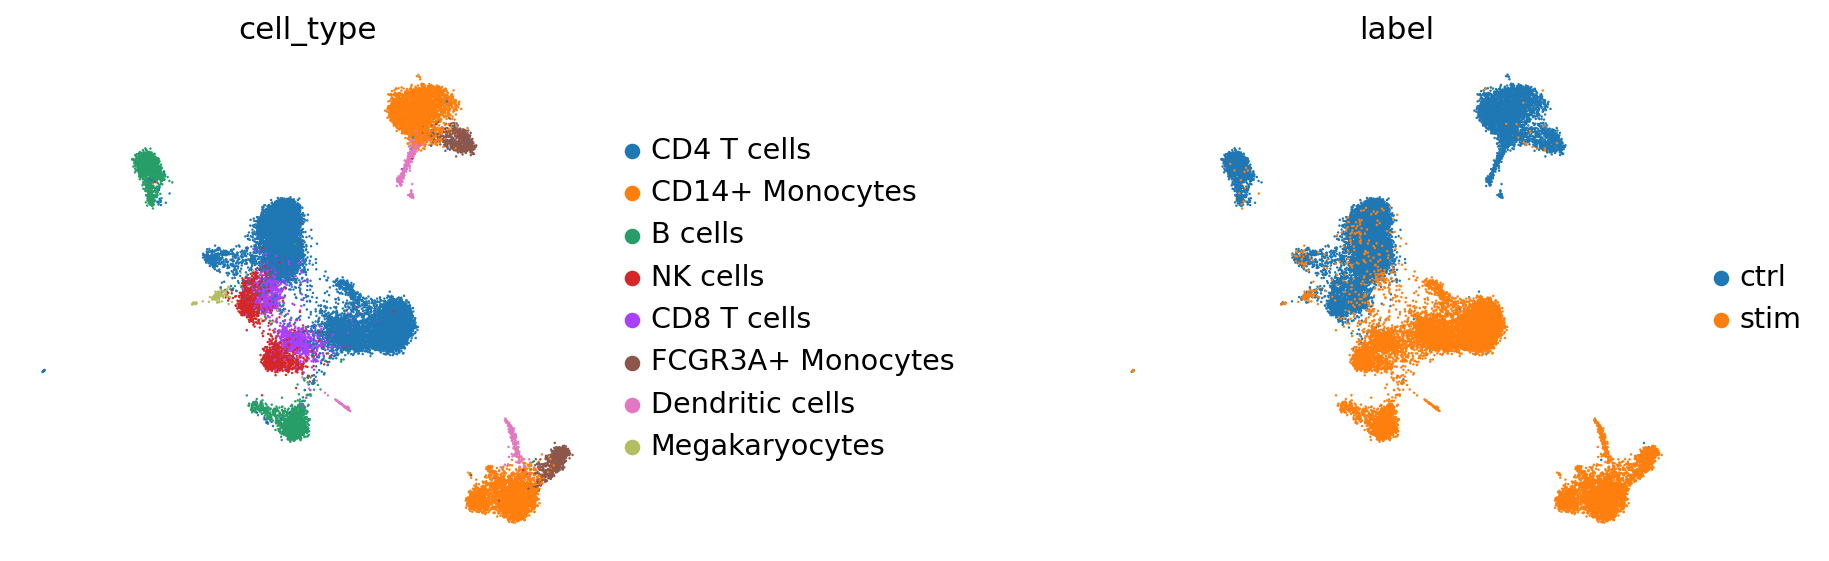

In [11]:
sc.pl.umap(
    adata, 
    color=["cell_type", "label"], 
    frameon=False,
    wspace = 0.7,
    ncols=2,
)

In [12]:
# put count data back
adata.X = adata.layers['counts']

In [13]:
adata.X = adata.X.A

In [14]:
# adata_ = adata.copy()
adata_ = adata_25k.copy()
adata_.X = adata_.X.A

In [15]:
%%R -i adata_
pbmc <- as.Seurat(adata_, counts = "X", data = NULL)
pbmc

/home/users/allstaff/hediyehzadeh.s/.local/lib/python3.9/site-packages/anndata2ri/r2py.py:102: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(exprs, obs, var, uns, obsm or None, layers=layers)


An object of class Seurat 
15706 features across 24673 samples within 1 assay 
Active assay: originalexp (15706 features, 0 variable features)
 2 dimensional reductions calculated: PCA, UMAP


In [16]:
%%R
pbmc = RenameAssays(object = pbmc, originalexp = 'RNA')

R[write to console]: Renaming default assay from originalexp to RNA



In [17]:
%%R
# scTransform normalisation in Seurat
pbmc <- SCTransform(object = pbmc, verbose = FALSE, variable.features.n = 2000)
pbmc

An object of class Seurat 
30364 features across 24673 samples within 2 assays 
Active assay: SCT (14658 features, 2000 variable features)
 1 other assay present: RNA
 2 dimensional reductions calculated: PCA, UMAP


In [18]:
%%R
x <- GetAssayData(object = pbmc, slot = 'data')# same as x <- bcdata[["SCT"]]@data, contains log-normalised values

In [19]:
%%R
grep('IFN', rownames(x), value = TRUE)

 [1] "IFNLR1"   "IFNGR1"   "IFNB1"    "IFNW1"    "IFNE"     "IFNG-AS1"
 [7] "IFNG"     "IFNAR2"   "IFNAR1"   "IFNGR2"  


In [20]:
%%R
print(table(pbmc$label))


 ctrl  stim 
12315 12358 


In [21]:
%%R
hvg <- VariableFeatures(object = pbmc)

In [22]:
umap_embed = adata.obsm["X_umap"]

In [23]:
%%R -i umap_embed
cell_embedding = umap_embed

In [24]:
%%R
HM_genesets[['HALLMARK_INTERFERON_ALPHA_RESPONSE']]

 [1] "MX1"      "ISG15"    "OAS1"     "IFIT3"    "IFI44"    "IFI35"   
 [7] "IRF7"     "RSAD2"    "IFI44L"   "IFITM1"   "IFI27"    "IRF9"    
[13] "OASL"     "EIF2AK2"  "IFIT2"    "CXCL10"   "TAP1"     "SP110"   
[19] "DDX60"    "UBE2L6"   "USP18"    "PSMB8"    "IFIH1"    "BST2"    
[25] "LGALS3BP" "ADAR"     "ISG20"    "GBP2"     "IRF1"     "PLSCR1"  
[31] "PSMB9"    "HERC6"    "SAMD9"    "CMPK2"    "IFITM3"   "RTP4"    
[37] "STAT2"    "SAMD9L"   "LY6E"     "IFITM2"   "HELZ2"    "CXCL11"  
[43] "TRIM21"   "PARP14"   "TRIM26"   "PARP12"   "NMI"      "RNF31"   
[49] "HLA-C"    "CASP1"    "TRIM14"   "TDRD7"    "DHX58"    "PARP9"   
[55] "PNPT1"    "TRIM25"   "PSME1"    "WARS1"    "EPSTI1"   "UBA7"    
[61] "PSME2"    "B2M"      "TRIM5"    "C1S"      "LAP3"     "LAMP3"   
[67] "GBP4"     "NCOA7"    "TMEM140"  "CD74"     "GMPR"     "PSMA3"   
[73] "PROCR"    "IL7"      "IFI30"    "IRF2"     "CSF1"     "IL15"    
[79] "CNP"      "TENT5A"   "IL4R"     "CMTR1"    "CD47"     "LPAR6"   
[85] "

In [25]:
%%R
pdf('lasso_plot.pdf')

selected_gs <- pruneGenesets(data = x, genesetlist = HM_genesets, hvg = hvg,
                            embedding = cell_embedding, min_gs_size = 3, lambda = exp(-3))
dev.off()

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.05

R[write to console]: Returning selected genesets with non-zero regression coefficients



[1] 2


In [26]:
cell_names = adata.obs_names

In [27]:
%%R -i cell_names

rownames(cell_embedding) = cell_names

In [28]:
%%R
print(table(pbmc$cell_type))


      CD4 T cells   CD14+ Monocytes           B cells          NK cells 
            11238              5697              2651              1716 
      CD8 T cells FCGR3A+ Monocytes   Dendritic cells    Megakaryocytes 
             1621              1089               529               132 


In [29]:
%%R
dim(pbmc)

[1] 14658 24673


processing-6.5

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.002

R[write to console]: Returning selected genesets with non-zero regression coefficients

R[write to console]: Learning geneset representations by CCA using 45 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
123456
123456789101112131415
123456789101112
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112

R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



processing-5.5

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.004

R[write to console]: Returning selected genesets with non-zero regression coefficients

R[write to console]: Learning geneset representations by CCA using 37 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
123456
123456789101112131415
123456789101112
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112

R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



processing-4

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.018

R[write to console]: Returning selected genesets with non-zero regression coefficients

R[write to console]: Learning geneset representations by CCA using 13 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
12345
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415


R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



processing-3.5

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.03

R[write to console]: Returning selected genesets with non-zero regression coefficients

R[write to console]: Learning geneset representations by CCA using 8 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
1234
12345678910
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415
123456789101112131415


R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



processing-2.5

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.082

R[write to console]: Returning selected genesets with non-zero regression coefficients

R[write to console]: Learning geneset representations by CCA using 3 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
1234
12345678
12345678910111213


R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



processing-1.5

R[write to console]: Computing optimal shrinkage value by cross-validation

R[write to console]: Fitting penalized multi-response gaussian GLM with alpha 0.223

R[write to console]: Returning selected genesets with non-zero regression coefficients

R[write to console]: Learning geneset representations by CCA using 2 dimensions...




 Permutation  1  out of  10  12345678910
 Permutation  2  out of  10  12345678910
 Permutation  3  out of  10  12345678910
 Permutation  4  out of  10  12345678910
 Permutation  5  out of  10  12345678910
 Permutation  6  out of  10  12345678910
 Permutation  7  out of  10  12345678910
 Permutation  8  out of  10  12345678910
 Permutation  9  out of  10  12345678910
 Permutation  10  out of  10  12345678910
1234
12


R[write to console]: Assigning cells to genesets in latent space...

R[write to console]: Verifying assignments by weighted k-nn...

R[write to console]: using 20 nearest neighbors and confidence threshold 0.5

R[write to console]: cell-geneset assignment completed.



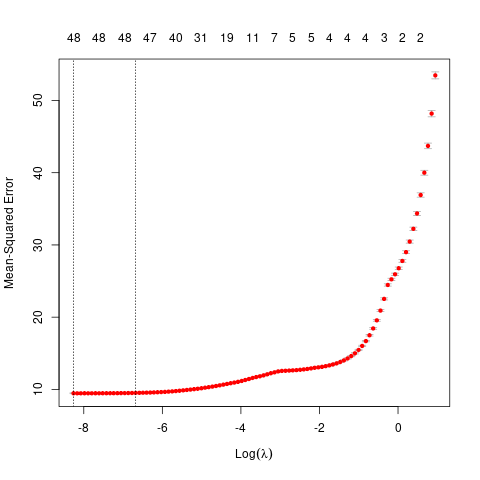

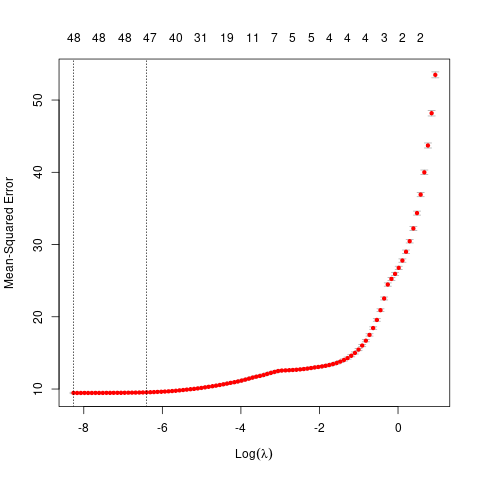

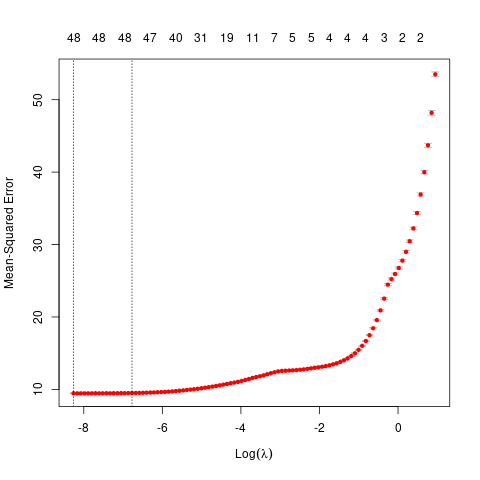

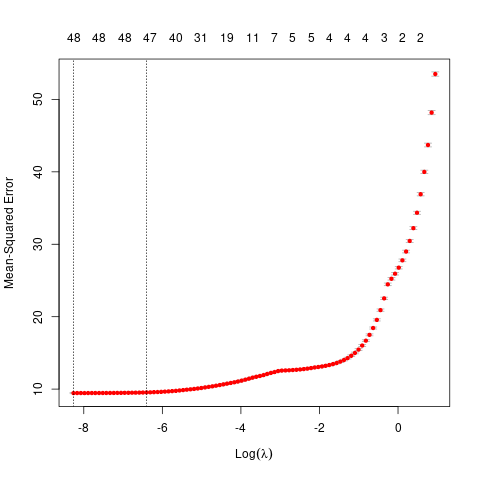

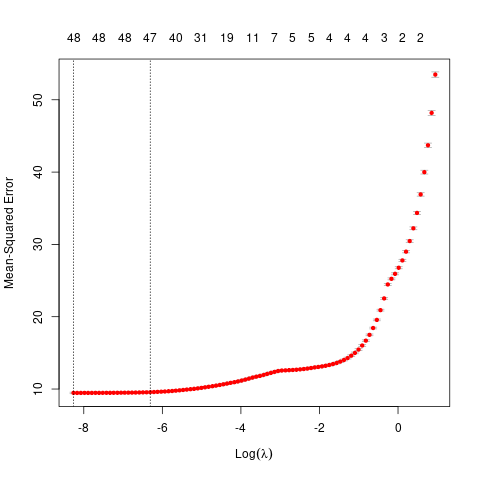

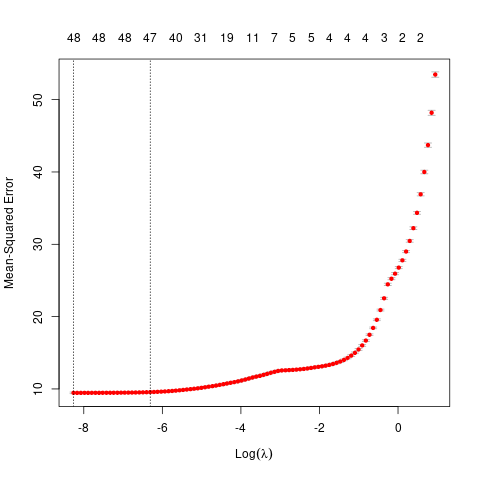

In [30]:
%%R
lambda_thresh <- c(-6.5, -5.5, -4, -3.5, -2.5, -1.5)
score_list <- list()
rsq_list <- list()
df_list <- list()

for(i in lambda_thresh){
    cat(paste0('processing',i))
    selected_gs <- pruneGenesets(data = x, genesetlist = HM_genesets, hvg = hvg,
                            embedding = cell_embedding, min_gs_size = 3, lambda = exp(i)) 
    target <- genesets2ids(x[match(hvg, rownames(x)),], HM_genesets[selected_gs])
    ann_res <- scDECAF(data = x, gs = target, standardize = FALSE, 
                   hvg = hvg, k = 20, embedding = cell_embedding,
                   n_components = ncol(target) - 1, max_iter = 2, thresh = 0.5)
    
    ann_res$label <- pbmc$label
    ann_res$cell_type <- pbmc$cell_type
#     idx <- which(ann_res$label=='stim' & ann_res$cell_type %in% c('CD14+ Monocytes','FCGR3A+ Monocytes'))
    idx <- which(ann_res$cell_type %in% c('CD14+ Monocytes','FCGR3A+ Monocytes'))

    idx_names <- ann_res$cell[idx]

    scores = attributes(ann_res)$raw_scores
    score_interferon = as.numeric(scale(scores[,'HALLMARK_INTERFERON_ALPHA_RESPONSE']))
#     score_interferon = scores[,'HALLMARK_INTERFERON_ALPHA_RESPONSE']
    names(score_interferon) = rownames(scores)
    score_list[as.character(i)] <- list(score_interferon)
    z <- score_list[[as.character(i)]][idx_names]
#     y <- x['IFNB1', idx_names]
    y <- colMeans(x[rownames(x) %in% HM_genesets[['HALLMARK_INTERFERON_ALPHA_RESPONSE']], idx_names])
    j <- !is.na(z)
    rsq_list[as.character(i)] <- summary(lm(y ~ z))$adj.r.squared
    res <- data.frame('score' = z,
                      'IFN_sig' = y,
                     'lambda' = as.character(i),
                     'adj_r_sq' = rsq_list[[as.character(i)]]
                     )
    df_list[[as.character(i)]] <- res
}
    
    

In [31]:
%%R 
rsq_list

$`-6.5`
[1] 0.1566789

$`-5.5`
[1] 0.1599332

$`-4`
[1] 0.2630214

$`-3.5`
[1] 0.399475

$`-2.5`
[1] 0.9151204

$`-1.5`
[1] 0.9325474



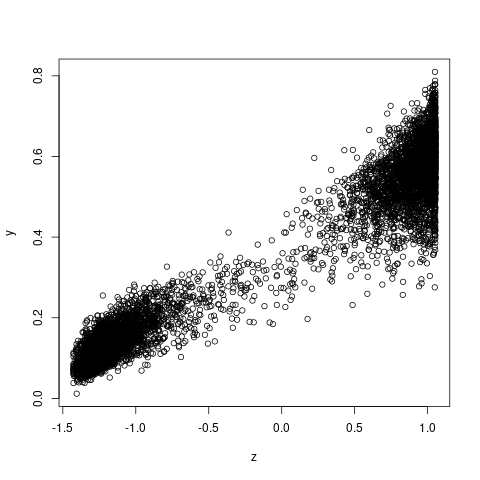

In [32]:
%%R


z <- score_list[[as.character(-1.5)]][idx_names]
#     y <- x['IFNB1', idx_names]
y <- colMeans(x[rownames(x) %in% HM_genesets[['HALLMARK_INTERFERON_ALPHA_RESPONSE']], idx_names])
j <- !is.na(z)
plot(z, y)

In [33]:
%%R
save(lambda_thresh, score_list, rsq_list, file = 'sparse_effect_experiment.RData')

In [34]:
%%R
length(df_list)

[1] 6


In [36]:
%%R
dim(df_list[[as.character(i)]])

[1] 6786    4


In [39]:
%%R
ggdat <- do.call(rbind, df_list)

In [40]:
%%R
print(head(ggdat))

                           score    IFN_sig lambda  adj_r_sq
-6.5.AAACATACATTTCC-1 -1.8351780 0.14425014   -6.5 0.1566789
-6.5.AAACATACCAGAAA-1 -1.2392088 0.07100597   -6.5 0.1566789
-6.5.AAACATACCTCGCT-1  0.4667989 0.11480365   -6.5 0.1566789
-6.5.AAACATACGCCAAT-1 -0.6362123 0.14599805   -6.5 0.1566789
-6.5.AAACATACGGCATT-1  0.1010489 0.13489858   -6.5 0.1566789
-6.5.AAACATTGCTTCGC-1 -1.0555590 0.16413258   -6.5 0.1566789


In [108]:
%%R
library(ggplot2)
lambda_label = paste0('log(lambda)= ',unique(ggdat$lambda))
# lambda_label = c(expression(log*lambda~"= -1.5"), expression(log*lambda~"= -2.5"),
#                 expression(log*lambda~"= -3.5"), expression(log*lambda~"= -4"),
#                 expression(log*lambda~"= -5.5"), expression(log*lambda~"= -6.5"))
names(lambda_label) = unique(ggdat$lambda)

ggdat_lm <- ggdat[!duplicated(ggdat$adj_r_sq),]
ggdat_lm$adj_r_sq <- round(ggdat_lm$adj_r_sq,2)

p <- ggplot(ggdat, aes(x=score, y = IFN_sig)) +
    geom_point(color="gray60")+  geom_smooth(method = "lm", color = "brown") + 
    geom_label(data = ggdat_lm, 
             aes(x = Inf, y = Inf, 
                 label = paste("R2 = ", adj_r_sq, sep = " ")),
             hjust = 1, vjust = 1) +
    facet_wrap(~lambda, labeller = label_bquote(log(lambda) ==.(lambda)), scales='free_x') +
    theme_linedraw()
ggsave("sparsity_effect_on_r2_score.pdf", p, width=8, height=6, dpi=250)

`geom_smooth()` using formula = 'y ~ x'


`geom_smooth()` using formula = 'y ~ x'


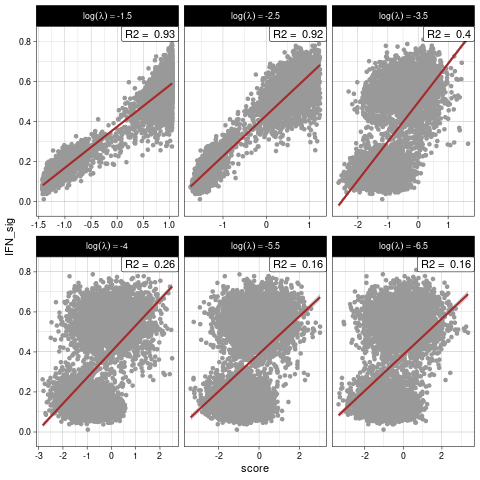

In [109]:
%%R
p